In [ ]:
from pycigar.utils.input_parser import input_parser
import numpy as np
from pycigar.utils.registry import register_devcon
from pycigar.controllers.regulator_attack_controller import RegulatorAttackController
import tensorflow as tf
from ray.rllib.models.catalog import ModelCatalog
from gym.spaces import Tuple, Discrete, Box

register_devcon('regulator_attack_controller', RegulatorAttackController)
misc_inputs = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee123busdata/misc_inputs.csv'
dss = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee123busdata/ieee123.dss'
load_solar = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee123busdata/load_solar_data.csv'
breakpoints = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee123busdata/breakpoints.csv'

def adjust_default_curves(base_config):
    for node in base_config['scenario_config']['nodes']:
        for d in node['devices']:
            name = d['name']
            c = np.array(d['custom_device_configs']['default_control_setting'])
            # found by training with no attack
            if name.endswith('a'):
                c = c + 0.04
            elif name.endswith('b'):
                c = c - 0.02
            elif name.endswith('c'):
                c = c + 0.01
            d['custom_device_configs']['default_control_setting'] = c
            d['custom_controller_configs']['default_control_setting'] = c
            d['adversary_custom_controller_configs']['default_control_setting'] = c
start = 100
sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, vectorized_mode=True, percentage_hack=0.4)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
for node in sim_params['scenario_config']['nodes']:
    node['devices'][0]['adversary_controller'] =  'unbalanced_fixed_controller'
#adjust_default_curves(sim_params)
from pycigar.envs import MultiAttackCentralControlPhaseSpecificPVInverterEnv
policy = "/home/toanngo/oscillation_ieee123_unbalance/main/run_train/run_train_1_T=150,lr=0.0004_2020-11-20_03-16-262pefpizn/best/policy_600"
env = MultiAttackCentralControlPhaseSpecificPVInverterEnv(sim_params=sim_params)
"""env.reset()
done = False
while not done:
    _, r, done, _ = env.step([10, 10, 10])"""
tf.compat.v1.enable_eager_execution()
policy = tf.saved_model.load(policy)
infer = policy.signatures['serving_default']
action_dist, _ = ModelCatalog.get_action_dist(Tuple([Discrete(21)] * 3), config={}, dist_type=None, framework='tf')
done = False
obs = env.reset()
obs = obs.tolist()
while not done:
    act_logits = infer(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['action_dist_inputs'].numpy()
    dist = action_dist(inputs=act_logits, model=None)
    act = np.array(dist.deterministic_sample()).flatten()
    obs, r, done, _ = env.step(act)
    obs = obs.tolist()

In [1]:
from pycigar.utils.logging import logger
import matplotlib.pyplot as plt
from pycigar.utils.output import plot_new
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics
plot_new(log_dict, custom_metrics, epoch='', unbalance=False, multiagent=False)

KeyError: 'start_time'

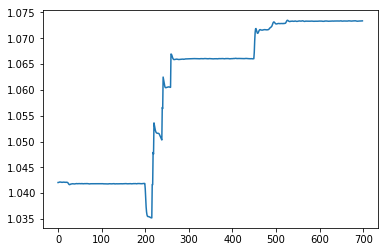

In [3]:
plt.plot(logger().log_dict['s1a']['voltage'])

In [4]:
node_8 = [[], [], []]
node_18 = [[], [], []]
for i in log_dict['v_metrics'].keys():
    node_8[0].append(log_dict['v_metrics'][i][0]['8'][0])
    node_8[1].append(log_dict['v_metrics'][i][0]['8'][1])
    node_8[2].append(log_dict['v_metrics'][i][0]['8'][2])

    node_18[0].append(log_dict['v_metrics'][i][0]['18'][0])
    node_18[1].append(log_dict['v_metrics'][i][0]['18'][1])
    node_18[2].append(log_dict['v_metrics'][i][0]['18'][2])

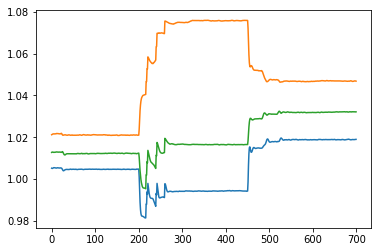

In [5]:
import numpy as np
plt.plot(np.array(node_18).T)

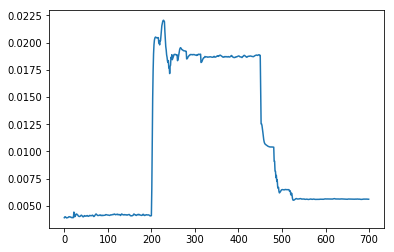

In [6]:
plt.plot(log_dict['u_metrics']['u_mean'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


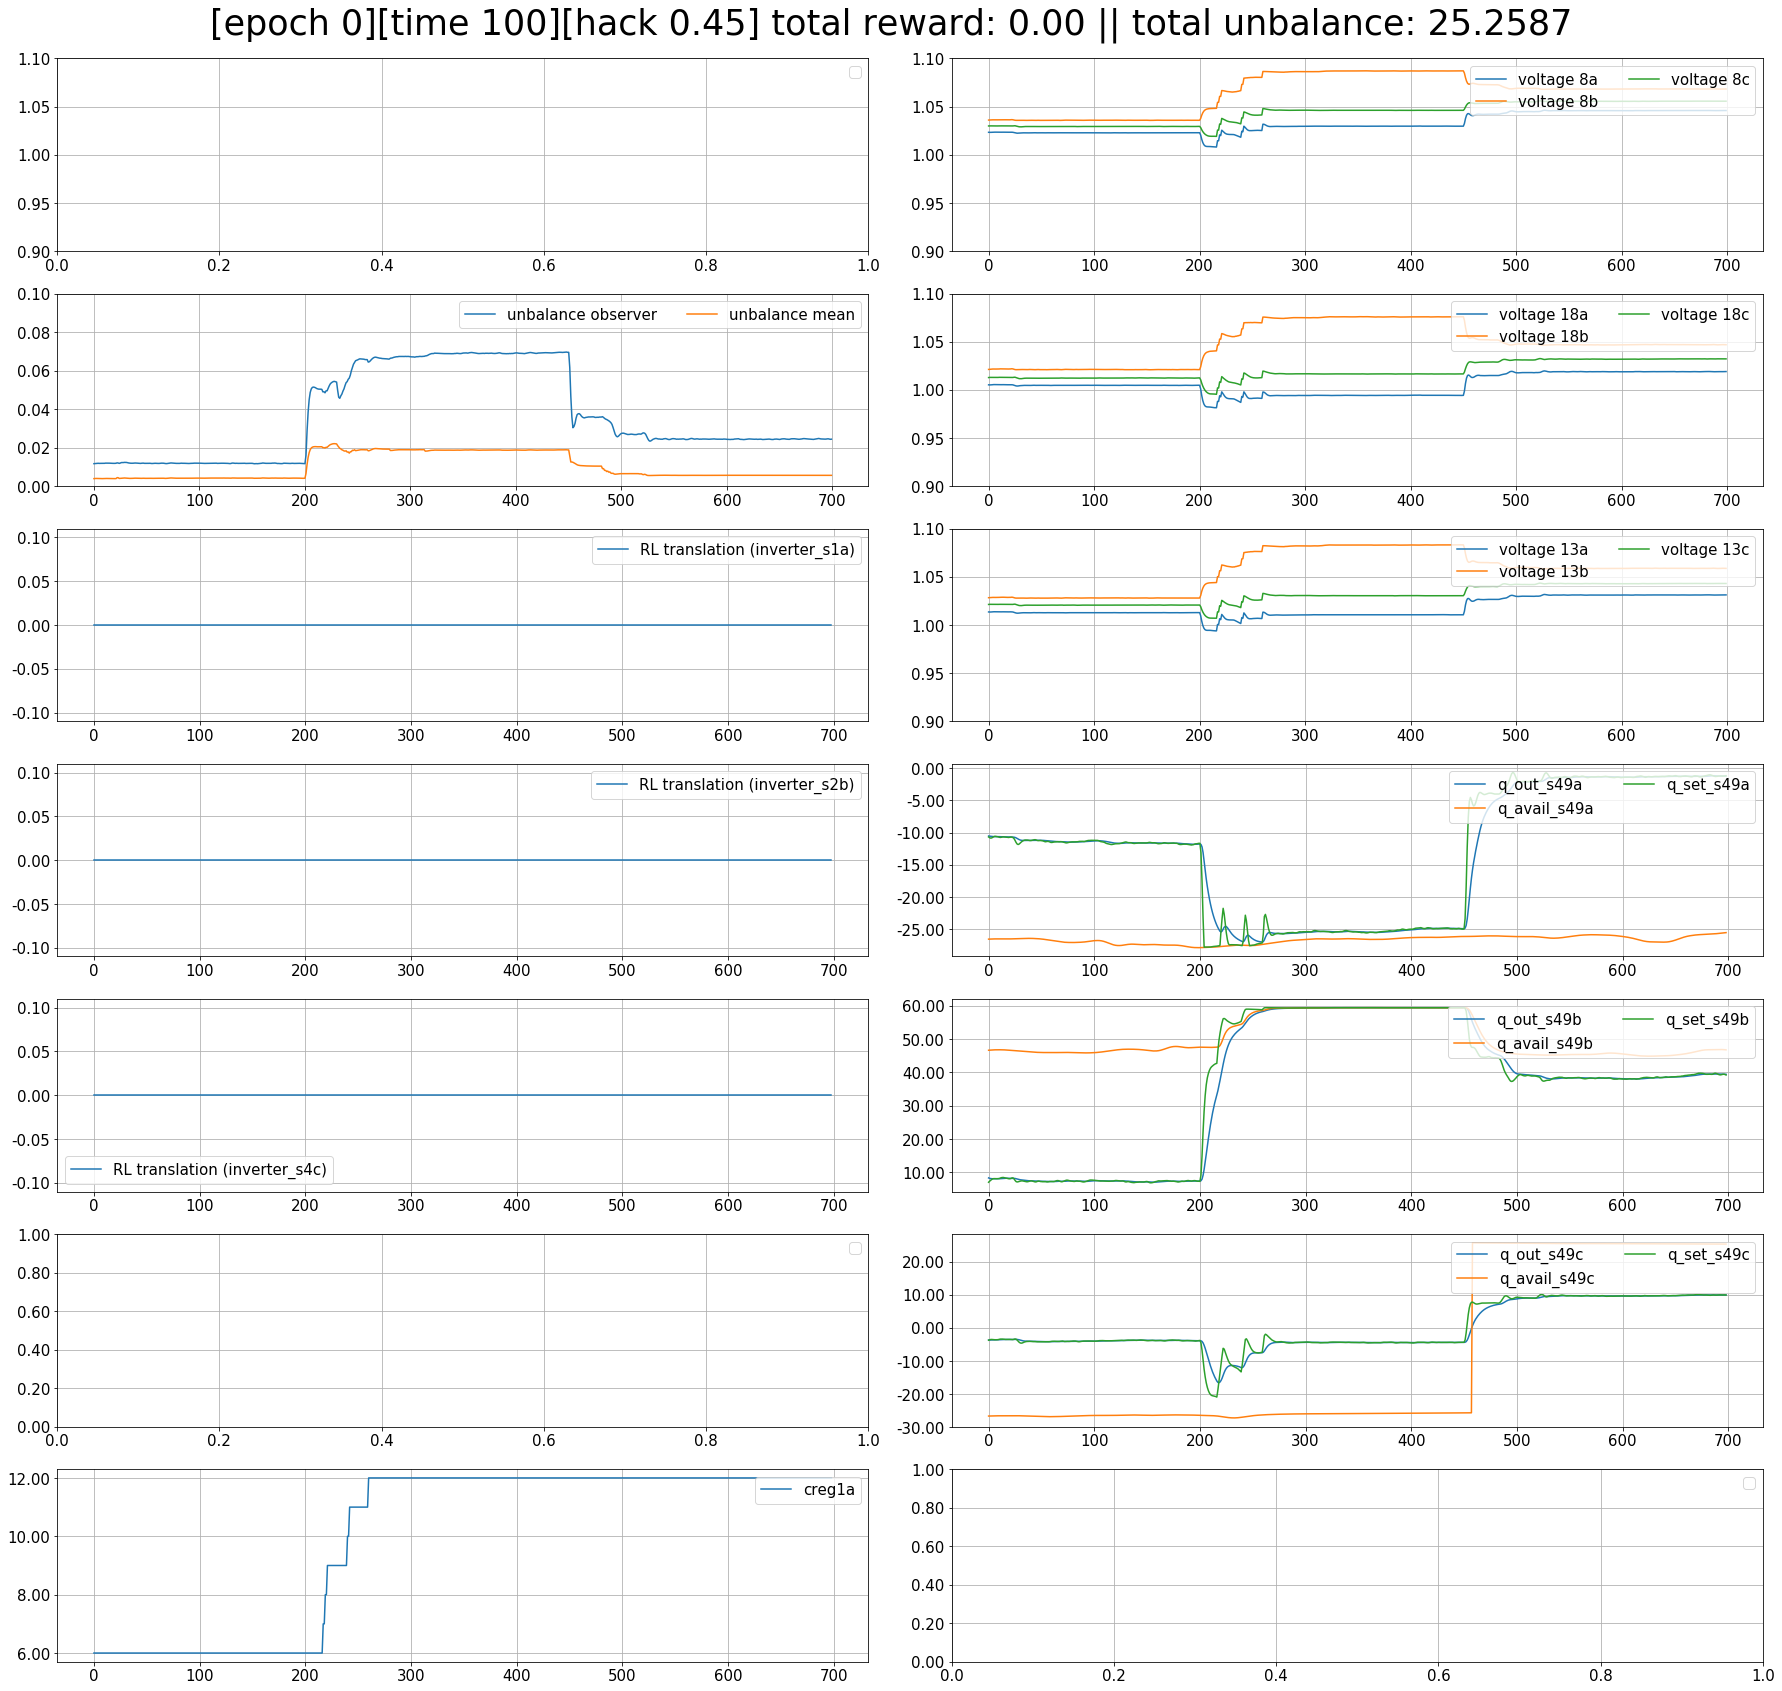

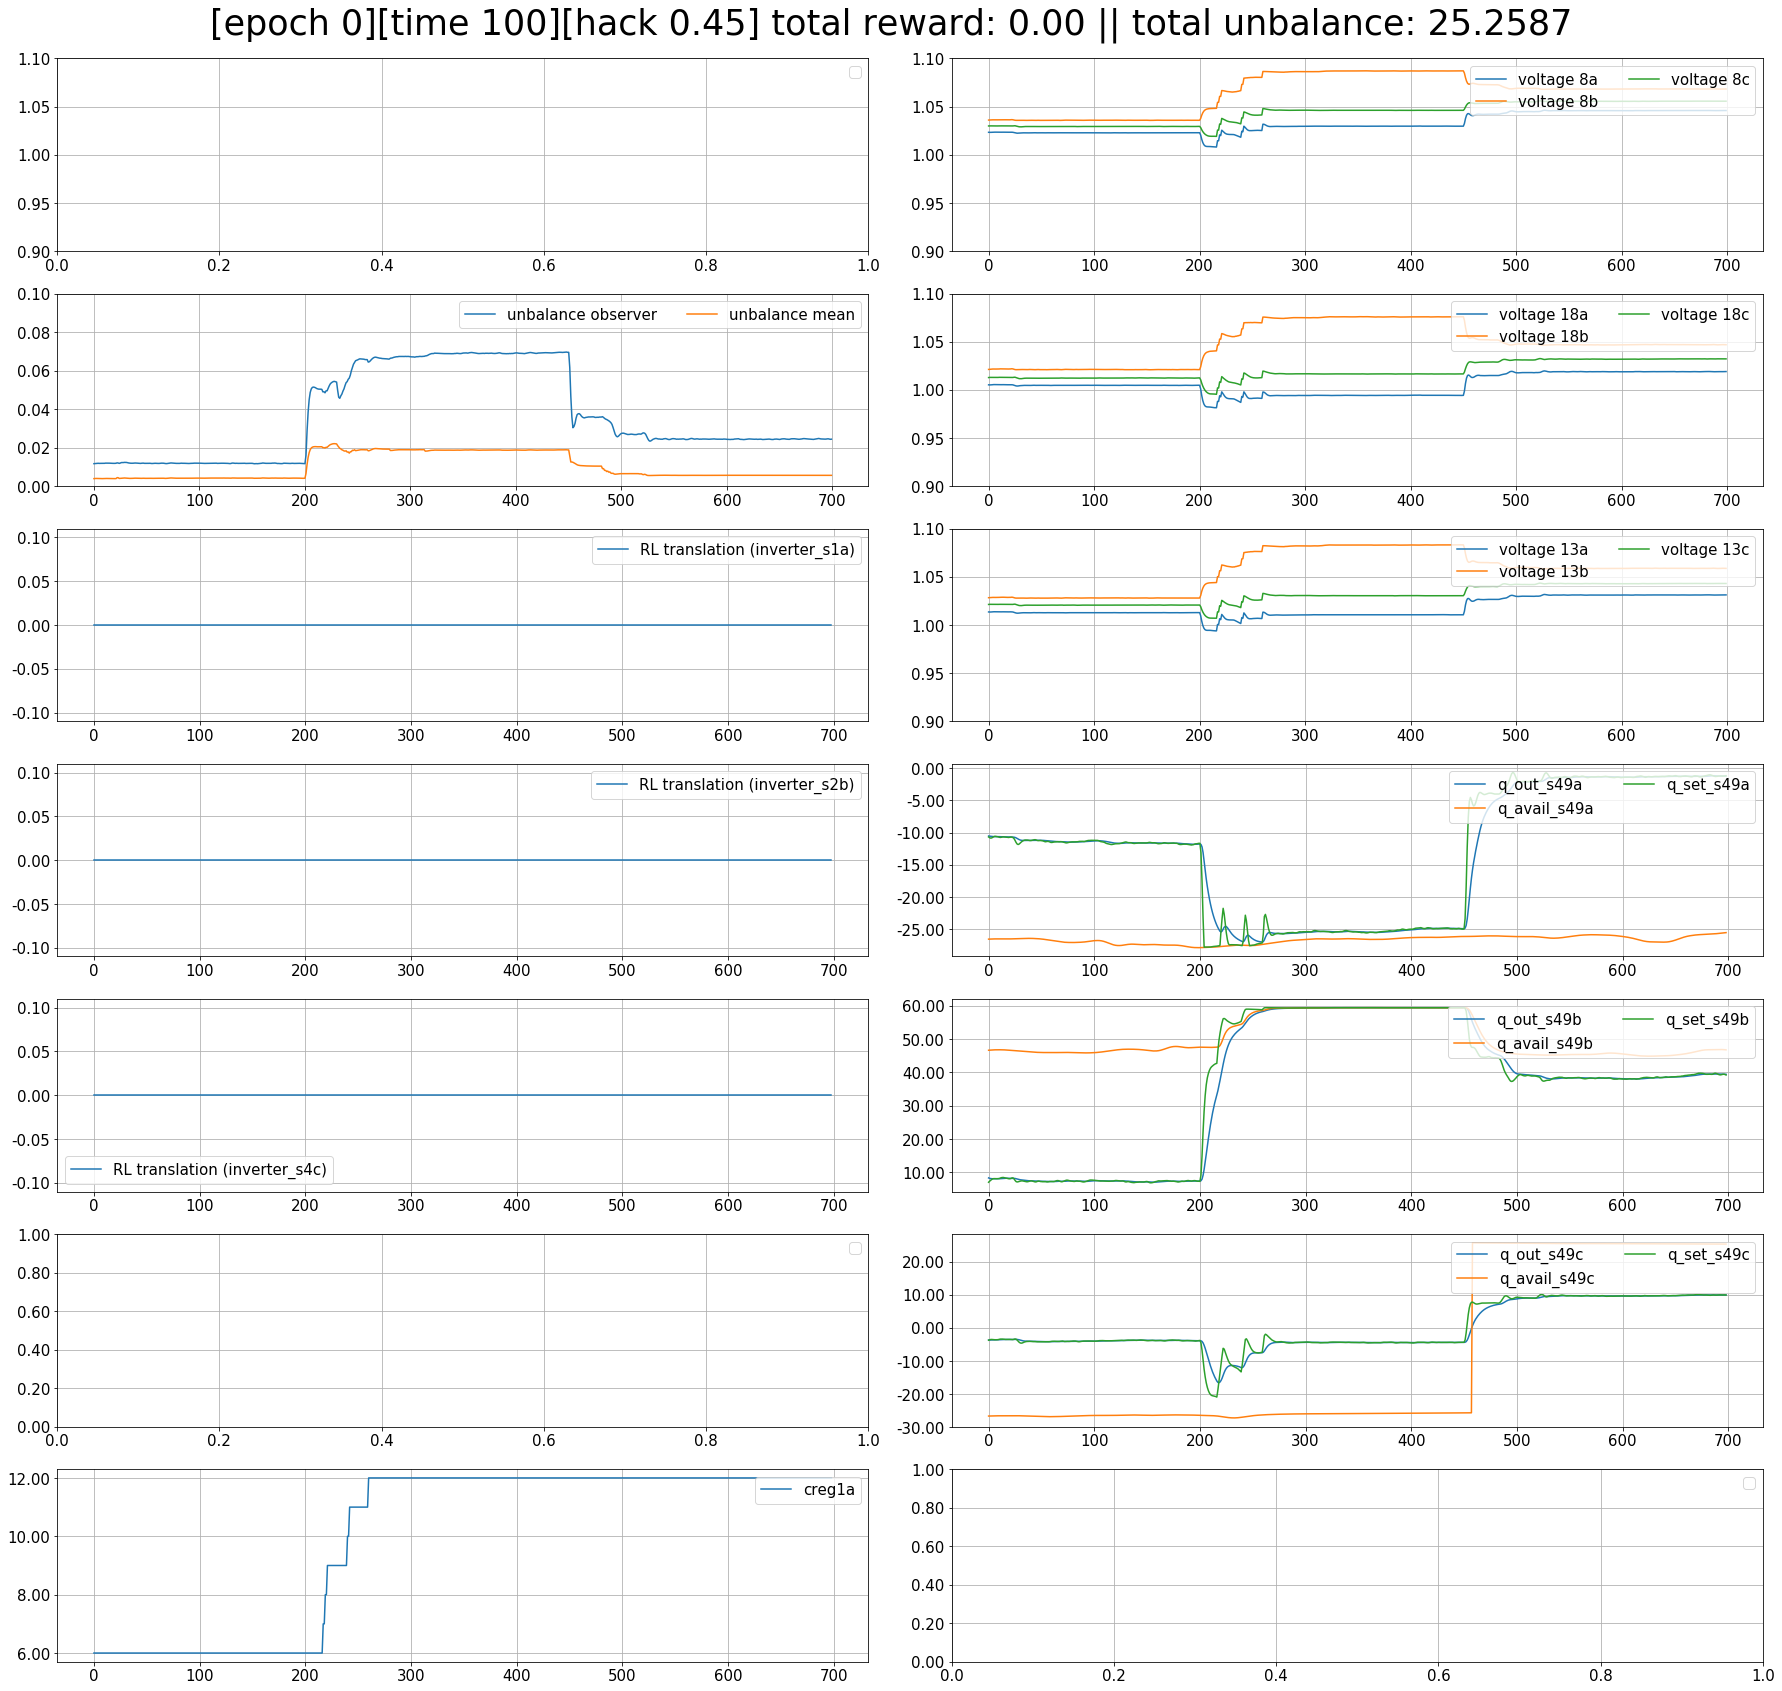

In [7]:
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new

log_dict = logger().log_dict
custom_metrics = logger().custom_metrics
plot_new(log_dict, custom_metrics, epoch='', unbalance=True, multiagent=False)

In [8]:
log_dict.keys()

dict_keys(['u_metrics', 'v_metrics', 'component_observation', 'current', 'inverter_s1a', 'adversary_inverter_s1a', 'inverter_s2b', 'adversary_inverter_s2b', 'inverter_s4c', 'adversary_inverter_s4c', 'inverter_s5c', 'adversary_inverter_s5c', 'inverter_s6c', 'adversary_inverter_s6c', 'inverter_s7a', 'adversary_inverter_s7a', 'inverter_s9a', 'adversary_inverter_s9a', 'inverter_s10a', 'adversary_inverter_s10a', 'inverter_s11a', 'adversary_inverter_s11a', 'inverter_s12b', 'adversary_inverter_s12b', 'inverter_s16c', 'adversary_inverter_s16c', 'inverter_s17c', 'adversary_inverter_s17c', 'inverter_s19a', 'adversary_inverter_s19a', 'inverter_s20a', 'adversary_inverter_s20a', 'inverter_s22b', 'adversary_inverter_s22b', 'inverter_s24c', 'adversary_inverter_s24c', 'inverter_s28a', 'adversary_inverter_s28a', 'inverter_s29a', 'adversary_inverter_s29a', 'inverter_s30c', 'adversary_inverter_s30c', 'inverter_s31c', 'adversary_inverter_s31c', 'inverter_s32c', 'adversary_inverter_s32c', 'inverter_s33a', 

In [9]:
log_dict['inverter_s49a'].keys()

dict_keys(['y', 'p_set', 'q_set', 'p_out', 'q_out', 'p_out_new', 'q_out_new', 'control_setting', 'sbar_solarirr', 'sbar_pset', 'solar_irr', 'reward'])

In [3]:
from pycigar.utils.logging import logger
import numpy as np   
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


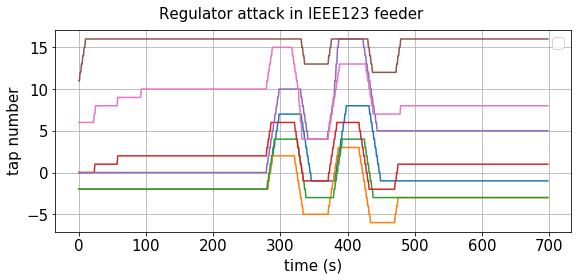

In [5]:
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics
regs = [k for k in log_dict if 'reg' in k]

f, ax = plt.subplots(figsize=(25/3, 4))
plt.rc('font', size=15)
plt.rc('figure', titlesize=15)
f.suptitle('Regulator attack in IEEE123 feeder')
for reg in regs:
    plt.plot(logger().log_dict[reg]['tap_number'])
ax.grid(b=True, which='both')
ax.legend(loc=1, ncol=1)

ax.set_xlabel('time (s)')
ax.set_ylabel('tap number')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()